In [1]:
from sklearn.datasets import make_circles, make_moons, make_swiss_roll, make_s_curve
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

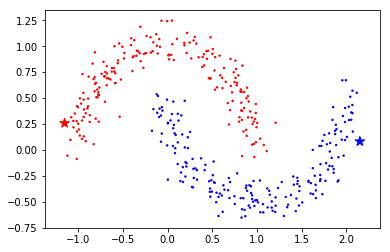

In [2]:
X, y = make_moons(n_samples=500, noise=0.1)
y[y == 0] = -1
seed = 1
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
max_idx = list(X[:, 0]).index(max(X[:, 0]))
min_idx = list(X[:, 0]).index(min(X[:, 0]))
idx = [max_idx, min_idx]

X_lab = X[idx]
y_lab = y[idx]

mask = np.ones(X[:, 0].shape, bool)
mask[idx] = False
X_unlab = X[mask]
y_unlab = y[mask]

X = np.concatenate((X_lab, np.repeat(X_unlab, 2, axis=0)))
y = np.concatenate((y_lab, np.repeat(y_unlab, 2, axis=0)))

colors = ['red','blue']
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c=y_unlab, cmap=matplotlib.colors.ListedColormap(colors), s=2)
plt.scatter(X_lab[:, 0], X_lab[:, 1], c=y_lab, cmap=matplotlib.colors.ListedColormap(colors), marker='*', s=100)

In [3]:
X_lab

array([[ 2.15171387,  0.08211003],
       [-1.15283991,  0.25789143]])

In [4]:
n_default = 2
def z_xij(xi, x, j, n=n_default):
    return n * (np.dot(xi, x) + 1)**(n-1) * x[j]

def z_xij_xpq(xi, xp, i, j, p, q, n=n_default):
    val = (n-1) * n * ((np.dot(xi, xp) + 1)**(n-2)) * xp[j] * xi[q]
    if j == p:
        val += n * (np.dot(xp, xi) + 1)**(n-1)
    return val

def poly(x1, x2, n=n_default):
    return (np.dot(x1, x2) + 1)**n

In [5]:
def z_xij_gaussian(xi, x, j, sigma=0.1):
    return 1/(sigma**2) * (x[j] - xi[j]) * np.exp(-1/(2*sigma**2) * LA.norm(xi-x)**2)

def z_xij_xpq_gaussian(xi, xp, j, q, sigma=0.1):
    if j != q:
        return -1/sigma**4 * (xi[j] - xp[j]) * (xi[q] - xp[q]) * np.exp(-1/(2*sigma**2) * LA.norm(xi-xp)**2)
    else:
        return 1/sigma**4 * (sigma**2 - (xi[j] - xp[j])**2) * np.exp(-1/(2*sigma**2) * LA.norm(xi-xp)**2)

def gaussian(x1, x2, sigma=0.1):
    return np.exp(-1/(2*sigma**2) * LA.norm(x1 - x2)**2)

In [6]:
X.shape

(798, 2)

In [7]:
l = 2
dim = X.shape[0]
K = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        if i < l and j < l:
            K[i, j] = gaussian(X[i], X[j])
        elif i >= l and j < l:
            idx = i % l
            K[i, j] = z_xij_gaussian(X[j], X[i], idx)
        elif i < l and j >= l:
            idx = j % l
            K[i, j] = z_xij_gaussian(X[i], X[j], idx)
        else:
            idx1 = i % l
            idx2 = j % l
            K[i, j] = z_xij_xpq_gaussian(X[i], X[j], idx1, idx2)

In [8]:
Dim = l + (dim-l)*2
length = dim - l
Q = np.zeros((Dim, Dim))
Q[l:l+length, l:l+length] = K[l:, l:]
Q[l:l+length, l+length:] = -K[l:, l:]
Q[l+length:, l:l+length] = -K[l:, l:]
Q[l+length:, l+length:] = K[l:, l:]

M = np.zeros((Dim, Dim))
M[:l, :l] = np.outer(y_lab, y_lab) * K[:l, :l]
G = M + Q

G[l:l+length, :l] = -K[l:, :l]
G[l+length:, :l] = K[l:, :l]
G[:l, l:l+length] = K[:l, l:]
G[:l, l+length:] = -K[:l, l:]

Y = np.ones((Dim, Dim))
Y[l:, :l] = np.tile(y_lab, [Dim-l, 1])
Y[:l, l:] = np.tile(y_lab, [Dim-l, 1]).T
P = G * Y

In [9]:
epsilon = 0.1
rho1 = 1
rho2 = 10000
q = np.zeros((Dim, 1))
q[:l] = -1
q[l:] = epsilon

N = np.vstack((np.eye(Dim)*(-1.),np.eye(Dim)))
constraint = np.zeros((Dim))
constraint[:l] = 1 / (2*rho1)
constraint[l:] = rho2 / (2*rho1)
h = np.hstack((np.zeros(Dim), constraint))

P = matrix(P)
q = matrix(q)
G = matrix(N)
h = matrix(h)
# run solver
sol = solvers.qp(P, q, G, h)
vals = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  3.9799e+05 -8.2429e+06  9e+06  3e-04  5e-09
 1:  3.6325e+05 -8.4441e+04  4e+05  2e-05  5e-09
 2:  3.6842e+03 -5.6831e+04  6e+04  1e-06  4e-09
 3:  5.6161e+01 -6.2654e+02  7e+02  1e-08  7e-11
 4:  4.8108e+00 -5.8137e+01  6e+01  1e-09  6e-12
 5: -8.6815e-02 -3.1904e+00  3e+00  3e-11  2e-13
 6: -7.4956e-01 -1.2712e+00  5e-01  5e-12  3e-14
 7: -8.4520e-01 -1.0141e+00  2e-01  1e-12  9e-15
 8: -8.8106e-01 -9.2161e-01  4e-02  2e-13  3e-15
 9: -8.9243e-01 -9.0150e-01  9e-03  4e-14  3e-15
10: -8.9517e-01 -8.9693e-01  2e-03  6e-15  2e-15
11: -8.9578e-01 -8.9604e-01  3e-04  8e-16  2e-15
12: -8.9587e-01 -8.9591e-01  4e-05  2e-16  2e-15
13: -8.9589e-01 -8.9589e-01  1e-06  2e-16  2e-15
14: -8.9589e-01 -8.9589e-01  2e-08  2e-16  3e-15
Optimal solution found.


In [10]:
beta = vals[0:l]
alpha_prime = vals[l:l+length]
alpha = vals[l+length:]
a = alpha_prime - alpha

In [11]:
sup_vec_idx = np.union1d(np.argwhere(np.logical_or(alpha_prime > 1e-2, alpha_prime < -1e-2)), np.argwhere(np.logical_or(alpha > 1e-2, alpha < -1e-2)))

In [12]:
def classify(x, beta, a, sup_vec_idx):
    val = 0
    for xi, b in zip(X_lab, beta):
        val += b * gaussian(xi, x)
    X_tmp = np.repeat(X_unlab, 2, axis=0)
    for idx in sup_vec_idx:
        j = idx % l
        val += a[idx] * z_xij_gaussian(X_tmp[idx], x, j)
    return np.sign(val)

In [13]:
res = []
for x in X_test:
    res.append(classify(x, beta, a, sup_vec_idx))
res = np.array(res)

In [14]:
np.sum((res.squeeze() == y_test).astype("int")) / y_test.shape[0]

0.71